In [358]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [359]:
file = "../data/nexus/LPR_Tl208_Ports/NEXT100_LPR_Tl208_PORT1a_slim.h5"

particles = pd.read_hdf(file, "parts")
all_hits = pd.read_hdf(file, "hits")


events = particles.event_id.unique()
print(events)

In [360]:
# Choose your event here
event = events[13]

parts = particles[particles.event_id == event]
hits = all_hits[all_hits.event_id == event]

In [361]:
pd.set_option('display.max_rows', 140) 
display(parts)
display(hits)

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,final_y,final_z,final_t,final_volume,kin_energy,length,creator_proc,final_proc
967,990013,1,Tl208,1,0,393.028717,397.628143,535.365295,0.000000,393.028717,397.628143,535.365295,0.000374,PORT_TUBE_AIR,0.000000e+00,0.000000e+00,none,RadioactiveDecay
968,990013,4,e-,0,1,393.028717,397.628143,535.365295,0.000374,392.525726,397.775360,535.803528,0.003941,PORT_TUBE_1a,4.968927e-01,9.598094e-01,RadioactiveDecay,eIoni
969,990013,3,anti_nu_e,0,1,393.028717,397.628143,535.365295,0.000374,12500.000000,2227.627197,-6331.875000,46.828621,WORLD,1.026909e+00,1.403875e+04,RadioactiveDecay,Transportation
970,990013,2,Pb208[3475.078],0,1,393.028717,397.628143,535.365295,0.000374,393.028717,397.628143,535.365295,0.000374,PORT_TUBE_AIR,1.612061e-07,0.000000e+00,RadioactiveDecay,RadioactiveDecay
971,990013,6,gamma,0,2,393.028717,397.628143,535.365295,0.000374,-461.612244,-326.049774,870.770020,3.900763,ICS,2.773668e-01,1.169307e+03,RadioactiveDecay,phot
972,990013,11,e-,0,6,-461.612244,-326.049774,870.770020,3.900763,-461.612244,-326.049774,870.770020,3.900763,ICS,5.797000e-05,1.447787e-07,phot,msc
973,990013,10,e-,0,6,-461.612244,-326.049774,870.770020,3.900763,-461.612244,-326.049774,870.770020,3.900763,ICS,5.797000e-05,1.447787e-07,phot,msc
974,990013,9,e-,0,6,-461.612244,-326.049774,870.770020,3.900763,-461.612244,-326.049774,870.770020,3.900763,ICS,8.708700e-04,1.509711e-05,phot,eIoni
975,990013,8,e-,0,6,-461.612244,-326.049774,870.770020,3.900763,-461.612244,-326.049866,870.770020,3.900765,ICS,7.906810e-03,3.292239e-04,phot,eIoni
976,990013,7,e-,0,6,-461.612244,-326.049774,870.770020,3.900763,-461.590027,-326.062042,870.780579,3.901056,ICS,2.684236e-01,1.396771e-01,phot,eIoni


,event_id,x,y,z,time,energy,label,particle_id,hit_id
4245,990013,310.035187,109.526543,312.615204,1.246262,0.000114,ACTIVE,13,0
4246,990013,310.035187,109.526527,312.615204,1.246265,0.000046,ACTIVE,22,0
4247,990013,310.035065,109.526611,312.615051,1.246338,0.000021,ACTIVE,21,0
4248,990013,310.035034,109.526680,312.615265,1.246317,0.000047,ACTIVE,20,0
4249,990013,310.035187,109.526581,312.615356,1.246301,0.000048,ACTIVE,19,0
...,...,...,...,...,...,...,...,...,...
4448,990013,311.547302,103.651810,313.347229,1.280102,0.001280,ACTIVE,32,12
4449,990013,311.550659,103.657959,313.351715,1.280308,0.000921,ACTIVE,32,13
4450,990013,311.553802,103.661385,313.347687,1.280476,0.001201,ACTIVE,32,14
4451,990013,311.554688,103.658226,313.349304,1.280597,0.000907,ACTIVE,32,15


In [366]:
# Add the mother information to the hits table
parts_mothers = parts[["particle_name","particle_id","mother_id", "creator_proc"]] # useful columns for identifying the mothers
hits_merged  = pd.merge(hits, parts_mothers, on='particle_id', how='inner')

# Function to get the creator proc, if eIoni, then need to find the parent process
def GetParentCreators(hits_merged_, parts_mothers):
    ioni_proc = hits_merged_ # hits merged here only contains eIoni rows
    ioni_proc = ioni_proc[["event_id","mother_id"]]

    # Merge the mother information to the eIoni columns
    ioni_proc_mother_merged = pd.merge(
        ioni_proc.reset_index(), 
        parts_mothers, 
        left_on='mother_id', 
        right_on='particle_id', 
        how='inner'
    )

    # Fix the indexing
    ioni_proc_mother_merged = ioni_proc_mother_merged[["index", "creator_proc"]]
    ioni_proc_mother_merged = ioni_proc_mother_merged.set_index("index", drop=True)
    ioni_proc_mother_merged.index.name = None

    # join the tables and then replace the eIoni with the parent creator if eIoni
    hits_merged_ = pd.merge(hits_merged_, ioni_proc_mother_merged, left_index=True, right_index=True, how='inner')
    hits_merged_['creator_proc_x'] = np.where(hits_merged_['creator_proc_x'] == "eIoni", hits_merged_['creator_proc_y'], hits_merged_['creator_proc_x'])
    hits_merged_ = hits_merged_.drop(['creator_proc_y'], axis=1)
    hits_merged_.rename(columns={'creator_proc_x': 'creator_proc'}, inplace=True)

    return hits_merged

# Calculate the distance from neighbouring points
def euclidean_distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2) ** 2))

# Function groups hits that are within ~ 1 step length together
# Will assign a new group, assumes neighbouring hits are created by same particle
def GetGroups(hits_merged):

    electrons = hits_merged[hits_merged.particle_name == "e-"]

    distance_cut = 1.5 # mm -- max step size is 1 mm

    # Loop over unique mothers
    electrons["group"] = 0
    electrons = electrons.reset_index(drop=True)

    group_index = 0

    # Loop over the rows
    for i in range(1, len(electrons)):
        prev_point = electrons.iloc[i - 1][['x', 'y', 'z']].to_numpy()
        curr_point = electrons.iloc[i][['x', 'y', 'z']].to_numpy()
        distance = euclidean_distance(curr_point,prev_point)

        if (distance < distance_cut):
            electrons.at[i-1, "group"] = group_index
        else:
            electrons.at[i-1, "group"] = int(group_index)
            group_index = mother_df.loc[i-1, "group"] = int(group_index + 1)

        if (i == len(electrons)-1):
            electrons.at[i, "group"] = int(group_index)


    # Group by 'group' and calculate mean of 'x', 'y', 'z', keep other columns
    # This collated all the hits into a row the mean positions for rows with the same group
    grouped = electrons.groupby('group').agg({
        'event_id': 'first',  # Keep the first event_id in each group
        'x': 'mean',          # Mean of x
        'y': 'mean',          # Mean of y
        'z': 'mean',          # Mean of z
        'energy': 'sum',      # Sum of energy
        'mother_id': 'first',  # Keep the first mother_id in each group
        'creator_proc': 'first'
    }).reset_index()
    
    return grouped, electrons

# Identify if any of the mother ids are electrons
# If they are then look at their mother to see if its a gamma
def GetParentName(parts, id_):
    parent = parts[parts.particle_id == id_]
    parent_name = parent["particle_name"].item()
    mother_id = parent["mother_id"].item()
    particle_id = parent["particle_id"].item()
    creator_proc = parent.creator_proc.item()

    if (creator_proc == "RadioactiveDecay"):
        creator_proc="RD"
    if (creator_proc == "phot" and parent_name == "gamma"):
        creator_proc="xray"


    if (parent.primary.item()==1):
        primary = True
    else:
        primary = False

    return parent_name, particle_id, mother_id, creator_proc, primary


# Replace ioni labels with the parent interaction process. 
eioni = len(hits_merged[hits_merged.creator_proc == "eIoni"])
while(eioni >0):
    hits_merged = GetParentCreators(hits_merged, parts_mothers)
    eioni = len(hits_merged[hits_merged.creator_proc == "eIoni"])

# Group the hits based on proximities
grouped, electrons  = GetGroups(hits_merged)

# Now we identify if any of the mother ids are electrons. If they are
#then look for their mother to see what gamma they came from
# also get information about how that gamma was made. e.g x-ray, radioactive decay (RD) or eBrem
new_labels = []
mother_creator_procs = []
for index, row in grouped.iterrows():
    parent_name = ""
    mother_id = row.mother_id
    while (parent_name != "gamma" or primary_flag):
        parent_name, particle_id, mother_id, creator_proc, primary_flag = GetParentName(parts, mother_id)
    new_labels.append(particle_id)
    mother_creator_procs.append(creator_proc)

grouped["mother_id"] = new_labels
grouped["init"]= mother_creator_procs

# Merge rows from duplicated entries
grouped = grouped.groupby(['mother_id', 'creator_proc'], as_index=False).agg({
    'event_id': 'first',  # Keep the first event_id in each group
    'x': 'mean',          # Mean of x
    'y': 'mean',          # Mean of y
    'z': 'mean',          # Mean of z
    'energy': 'sum',       # Sum of energy
    'group' : 'first',
    'init' : 'first'
})

display(grouped) 

/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_99242/1196478790.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  electrons["group"] = 0


,mother_id,creator_proc,event_id,x,y,z,energy,group,init
0,13,phot,990013,317.466248,99.650871,304.518311,0.553292,0,RD
1,15,phot,990013,311.418182,107.377991,315.555969,0.029666,1,xray


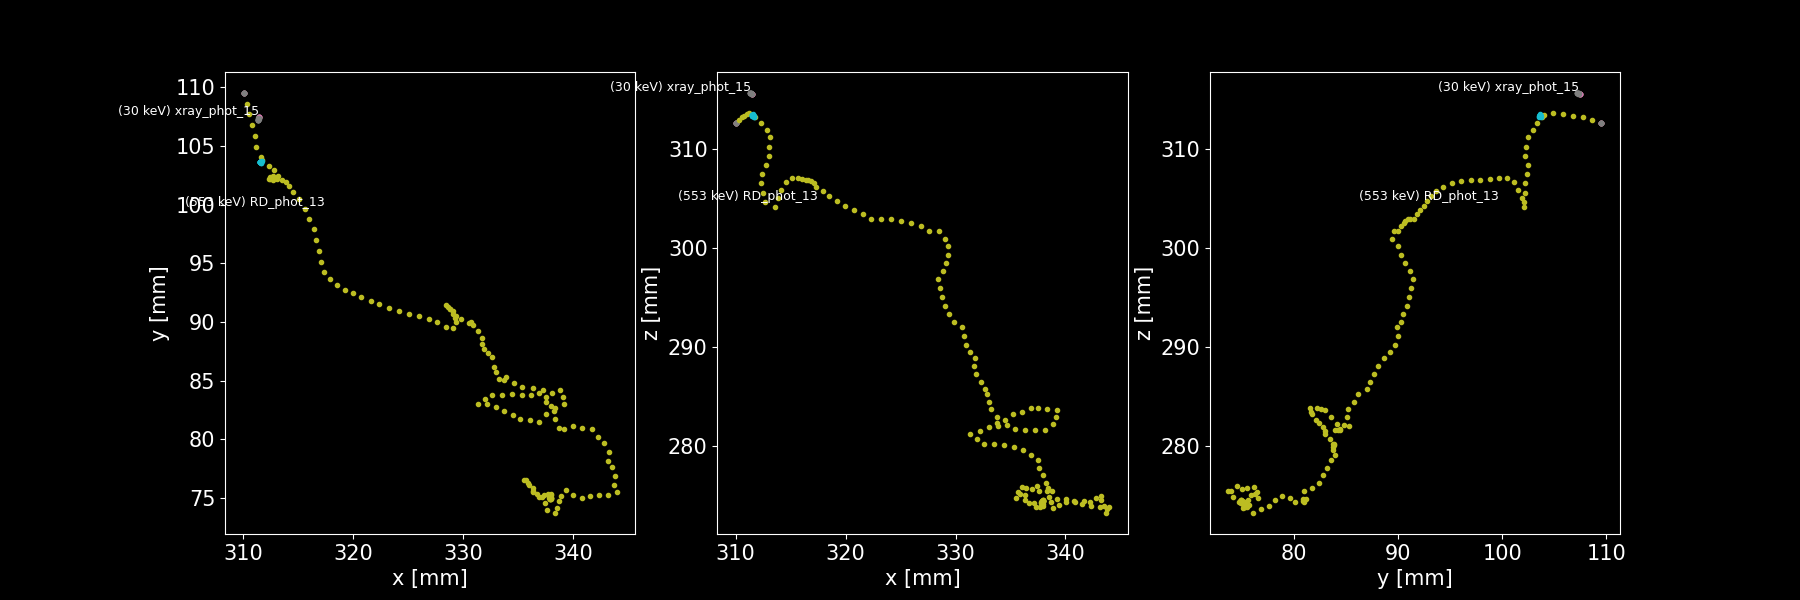

In [365]:
%matplotlib widget

def Plot2D(ax, x_label, y_label, hits, grouped):

    fig.set_facecolor('black')
    ax.set_facecolor('black')

    for p in hits.particle_id.unique():
        ax.plot(hits[hits.particle_id == p][x_label], hits[hits.particle_id == p][y_label], ".")

    ax.set_xlabel(f"{x_label} [mm]", fontsize = 15)
    ax.set_ylabel(f"{y_label} [mm]", fontsize = 15)
    ax.tick_params(axis='both', which='both', labelsize=15)  # Adjust labelsize as needed

    # Set the color of the axes labels and ticks to white
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')

    # Set the color of the spines (borders) to white
    ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.spines['left'].set_color('white')

    for index, row in grouped.iterrows():
        Energy =round(row["energy"]*1000)
        ax.text(row[x_label], row[y_label], f"({Energy} keV) {row.init}_{row.creator_proc}_{row.mother_id}", fontsize=9, ha='right', va='bottom', color='white')
        # ax.text(row[x_label]-5, row[y_label]-5, f"{Energy} keV", fontsize=9, ha='right', va='bottom', color='white')


fig, axs = plt.subplots(1, 3, figsize=(18, 6))
Plot2D(axs[0], "x", "y", hits, grouped)
Plot2D(axs[1], "x", "z", hits, grouped)
Plot2D(axs[2], "y", "z", hits, grouped)


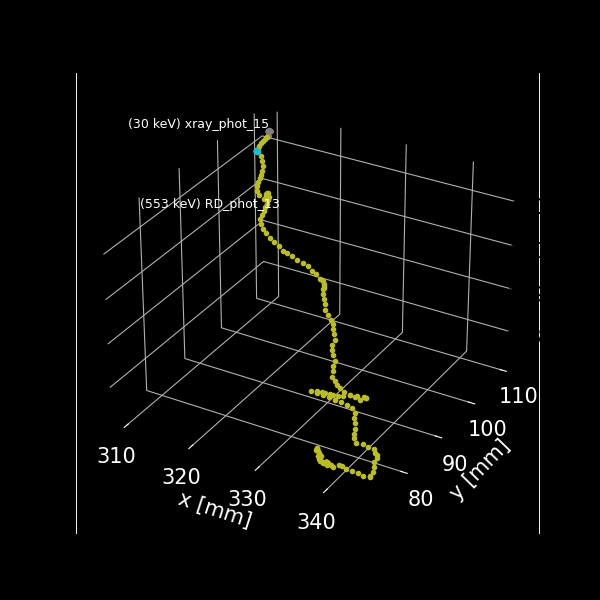

In [364]:
%matplotlib widget

fig, ax  = plt.subplots(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')

for p in hits.particle_id.unique():
    plt.plot(hits[hits.particle_id == p].x, hits[hits.particle_id == p].y, hits[hits.particle_id == p].z,  ".")


ax.set_xlabel("x [mm]", fontsize = 15)
ax.set_ylabel("y [mm]", fontsize = 15)
ax.tick_params(axis='both', which='both', labelsize=15)  # Adjust labelsize as needed

# Set the color of the axes labels and ticks to white
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

# Set the color of the spines (borders) to white
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')

# Set axis face colors to black
ax.w_xaxis.set_pane_color((0, 0, 0, 1))  # X-axis face
ax.w_yaxis.set_pane_color((0, 0, 0, 1))  # Y-axis face
ax.w_zaxis.set_pane_color((0, 0, 0, 1))  # Z-axis face

# Plot the text
for index, row in grouped.iterrows():
    Energy =round(row["energy"]*1000)
    ax.text(row["x"], row["y"], row["z"], f"({Energy} keV) {row.init}_{row.creator_proc}_{row.mother_id}", fontsize=9, ha='right', va='bottom', color='white')